In [1]:
import sys
sys.path.append('..')

from data.split_dataset import _load_data_channelwise_fpath_hagen as load_hagen_raw
import numpy as np


In [24]:
import os
from skimage.io import imread


def load_tiff(path):
    """
    Returns a 4d numpy array: num_imgs*h*w*num_channels
    """
    data = imread(path, plugin='tifffile')
    return data

# def load_hagen_gt():
#     gt_data = load_hagen_raw(['/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
#                         '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'])
#     ch1 = np.stack(gt_data[0])
#     ch2 = np.stack(gt_data[1])
#     data = np.concatenate([ch1[...,None], ch2[...,None]], axis=-1)
#     return data

def load_predictions_raw(direc):
    bt_removed = load_tiff(os.path.join(direc,'bt_removed_pred.tif'))
    dim_pred = load_tiff(os.path.join(direc, 'dim_pred.tif'))
    return bt_removed, dim_pred

def load_predictions_indisplit(rootdir, modelpath, mixing_t_ood):
    "Hagen/MitoVsAct/LeanLC/"
    fpath = os.path.join(rootdir,'predictions','_'.join(modelpath.split('/')), f'T-{mixing_t_ood}_MMSE-10_InferT-1_InferTAgg-1_FixedT-None')
    return load_predictions_raw(fpath), fpath

def load_predictions_indi(rootdir, modelpath, mixing_t_ood):
    "Hagen/MitoVsAct/LeanLC/"
    fpath = os.path.join(rootdir,'predictions','_'.join(modelpath.split('/')), f'T-{mixing_t_ood}_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.5')
    return load_predictions_raw(fpath), fpath

def load_input_tar(rootdir, indisplit_modelpath, mixing_t_ood):
    """
    /group/jug/ashesh/indiSplit/predictions/2502_Hagen-joint_indi-l1_57/InpVsTar_T-0.1/
    """
    direc = os.path.join(rootdir, 'predictions', '_'.join(indisplit_modelpath.split('/')), f'InpVsTar_T-{mixing_t_ood}')
    inp = load_tiff(os.path.join(direc, 'input.tif'))
    tar = load_tiff(os.path.join(direc, 'target.tif'))
    return (inp, tar)

def load_predictions_denoisplit(rootdir, modelpath, mixing_t_ood):
    """
    /group/jug/ashesh/indiSplit/prediction_baselines/denoiSplit_2502_D7-M3-S0-L0_7_T-0.1_MMSE-10/pred.tif
    """
    smaller_w = min(mixing_t_ood, 1-mixing_t_ood)
    larger_w = max(mixing_t_ood, 1-mixing_t_ood)
    model_str = '_'.join(modelpath.split('/'))
    fpath_schema = os.path.join(rootdir, 'prediction_baselines', 'denoiSplit_{model_str}_T-{w}_MMSE-10', 'pred.tif')
    smaller_w_data = load_tiff(fpath_schema.format(w=smaller_w, model_str=model_str))
    larger_w_data = load_tiff(fpath_schema.format(w=larger_w, model_str=model_str))
    return (smaller_w_data, larger_w_data), fpath_schema.format(w=smaller_w, model_str=model_str)

def load_predictions_usplit_unet(rootdir, modelpath, mixing_t_ood):
    """
    /group/jug/ashesh/indiSplit/prediction_baselines/uSplit_2502_D13-M3-S0-L0_6_T-0.1_MMSE-10/pred.tif
    """
    smaller_w = min(mixing_t_ood, 1-mixing_t_ood)
    larger_w = max(mixing_t_ood, 1-mixing_t_ood)
    model_str = '_'.join(modelpath.split('/'))
    fpath_schema = os.path.join(rootdir, 'prediction_baselines', 'uSplit_{model_str}_T-{w}_MMSE-10', 'pred.tif')
    smaller_w_data = load_tiff(fpath_schema.format(w=smaller_w, model_str=model_str))
    larger_w_data = load_tiff(fpath_schema.format(w=larger_w, model_str=model_str))
    return (smaller_w_data, larger_w_data), fpath_schema.format(w=smaller_w, model_str=model_str)


In [54]:
import os

rootdir = '/group/jug/ashesh/indiSplit'
mixing_t_ood = 0.5
dset = 'biosr'
model_subdirs = {
    'hagen':{
        'unet': '2211/D7-M10-S0-L3/1',
        'indi': '2502/Hagen-joint_indi-l1/58',
        'indisplit': '2502/Hagen-joint_indi-l1/57',
        'denoisplit': '2502/D7-M3-S0-L0/7',
        'leanlc': 'Hagen/MitoVsAct/LeanLC/',
        'regularlc': '2210/D7-M3-S0-L0/78',
        'deeplc': 'Hagen/MitoVsAct/DeepLC/'
    },
    'biosr':{
        'unet':"2502/D13-M10-S0-L3/1",
        'indi':"2502/BioSR-joint_indi-l1/6",
        'indisplit':"2502/BioSR-joint_indi-l1/5",
        'denoisplit':"2502/D16-M3-S0-L0/5",
        'leanlc':"2502/D13-M3-S0-L0/6",
        'regularlc':"2502/D13-M3-S0-L0/9",
        'deeplc':"2502/D13-M3-S0-L0/8"
    }
}
inp,tar = load_input_tar(rootdir, model_subdirs[dset]['indisplit'], mixing_t_ood)
unet_data, unet_fpaths = load_predictions_usplit_unet(rootdir, model_subdirs[dset]['unet'], mixing_t_ood)
indi_data, indi_fpaths = load_predictions_indi(rootdir, model_subdirs[dset]['indi'], mixing_t_ood)
indisplit_data, indisplit_fpaths = load_predictions_indisplit(rootdir, model_subdirs[dset]['indisplit'], mixing_t_ood)#load_predictions(os.path.join(rootdir,'predictions','_'.join(model_subdirs[dset]['indisplit'].split('/')), f'T-{mixing_t_ood}_MMSE-10_InferT-1_InferTAgg-1_FixedT-None'))
denoiSplit_data, denoisplit_fpaths = load_predictions_denoisplit(rootdir, model_subdirs[dset]['denoisplit'], mixing_t_ood)
leanlc_data, leanlc_fpaths = load_predictions_usplit_unet(rootdir, model_subdirs[dset]['leanlc'], mixing_t_ood)
regularlc_data, regularlc_fpaths = load_predictions_usplit_unet(rootdir, model_subdirs[dset]['regularlc'], mixing_t_ood)
deeplc_data, deeplc_fpaths = load_predictions_usplit_unet(rootdir, model_subdirs[dset]['deeplc'], mixing_t_ood)

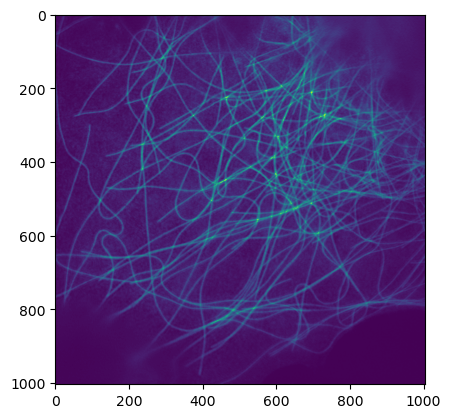

In [55]:
plt.imshow(tar[0,...,0])

In [57]:
test_data = load_tiff('/group/jug/ashesh/data/diffsplit_BioSR/Microtubules-vs-ER/test/test.tif')

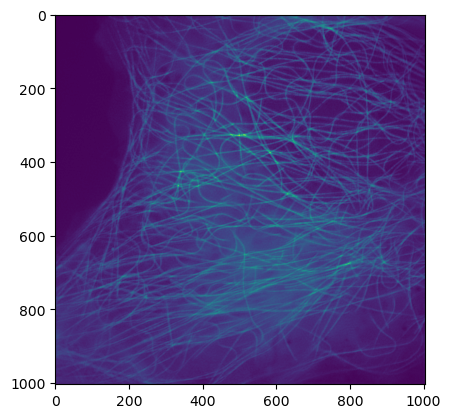

In [59]:
plt.imshow(test_data[0,...,0])

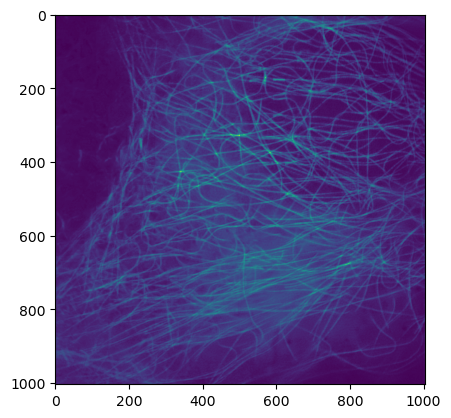

In [56]:
plt.imshow(unet_data[0][0,...,0])

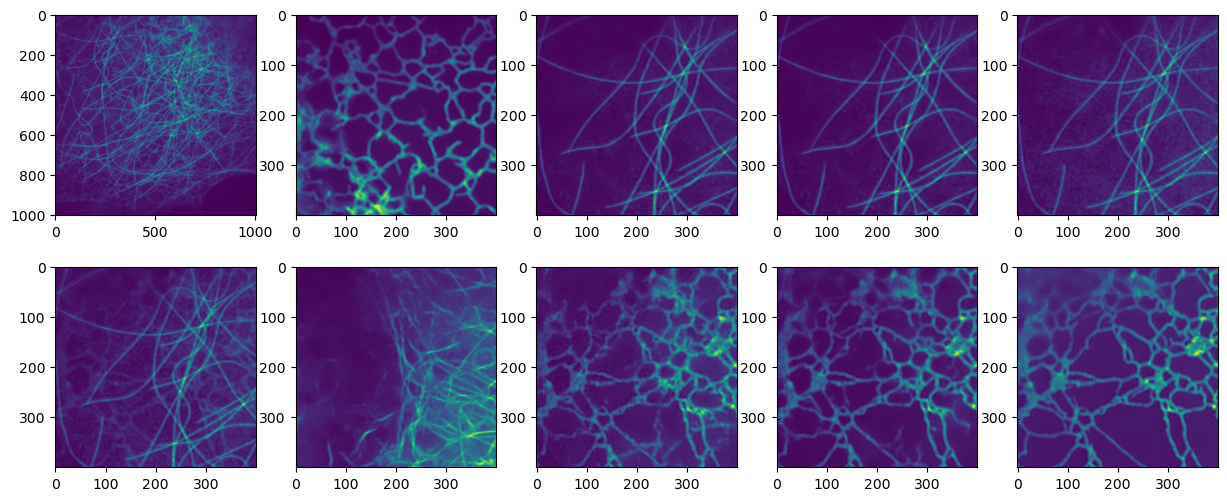

In [43]:
import matplotlib.pyplot as plt

hs = 0
ws = 0
sz = 400
img_idx = 0
# inp, deepLC, inDI, indiSplit, tar
_,ax = plt.subplots(figsize=(15,6),ncols=5,nrows=2)
ax[0,0].imshow(inp[img_idx,...,0])
ax[1,0].imshow(inp[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[0,1].imshow(denoiSplit_data[1][img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,1].imshow(denoiSplit_data[1][img_idx,hs:hs+sz,ws:ws+sz,1])
ax[0,2].imshow(indi_data[1][img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,2].imshow(indi_data[1][img_idx,hs:hs+sz,ws:ws+sz,1])
ax[0,3].imshow(indisplit_data[1][img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,3].imshow(indisplit_data[1][img_idx,hs:hs+sz,ws:ws+sz,1])
ax[0,4].imshow(tar[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,4].imshow(tar[img_idx,hs:hs+sz,ws:ws+sz,1])


In [40]:
leanlc_fpaths, indi_fpaths

('/group/jug/ashesh/indiSplit/prediction_baselines/uSplit_2502_D13-M3-S0-L0_6_T-0.3_MMSE-10/pred.tif',
 '/group/jug/ashesh/indiSplit/predictions/2502_BioSR-joint_indi-l1_6/T-0.3_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.5')

In [55]:
load_tiff('/group/jug/ashesh/data/diffsplit_BioSR/Microtubules-vs-ER/test/test.tif').shape

(5, 1004, 1004, 2)